This code will load .VEC files, analyze and detect vortecies and calculate the frequency of vortex shedding

In [1]:
import pathlib
import importlib.resources
import numpy as np
import matplotlib.pyplot as plt
import vortexfitting.schemes as vfSchemes
import vortexfitting.fitting as vfFitting
import vortexfitting.detection as vfDetection
import vortexfitting.output as vfOutput
from netCDF4 import Dataset
from pivpy import io, graphics, inter
import xarray as xr
import os

In [2]:
try:
    path = r"C:\Users\guyro\Desktop\UNI TAU\3RD YEAR\A\RESEARCH PROJECT\Vortex detection\Vortex findinf\VEC MAP" #Path to directory containing .vec files
    contents = os.listdir(path)
    print(contents) #content of the directory
except:
    path = '/home/user/Downloads/GuyRon_Analysis/'
    contents = os.listdir(path)
    print(contents) #content of the directory

['data.nc', 'interTest', 'NetCFD_Files', 'run1_210824_002000.T000.D000.P000.H000.L.vec', 'run1_210824_002001.T000.D000.P000.H000.L.vec', 'run1_210824_002002.T000.D000.P000.H000.L.vec', 'run1_210824_002003.T000.D000.P000.H000.L.vec', 'run1_210824_002004.T000.D000.P000.H000.L.vec', 'run1_210824_002005.T000.D000.P000.H000.L.vec', 'run1_210824_002006.T000.D000.P000.H000.L.vec', 'run1_210824_002007.T000.D000.P000.H000.L.vec', 'run1_210824_002008.T000.D000.P000.H000.L.vec', 'run1_210824_002009.T000.D000.P000.H000.L.vec', 'run1_210824_002010.T000.D000.P000.H000.L.vec', 'run1_210824_002011.T000.D000.P000.H000.L.vec', 'run1_210824_002012.T000.D000.P000.H000.L.vec', 'run1_210824_002013.T000.D000.P000.H000.L.vec', 'run1_210824_002014.T000.D000.P000.H000.L.vec', 'run1_210824_002015.T000.D000.P000.H000.L.vec', 'run1_210824_002016.T000.D000.P000.H000.L.vec', 'run1_210824_002017.T000.D000.P000.H000.L.vec', 'run1_210824_002018.T000.D000.P000.H000.L.vec', 'run1_210824_002019.T000.D000.P000.H000.L.vec',

In [3]:
path = pathlib.Path(path) #convert path from string to Path object
assert path.exists() #Checking if the path exists

In [4]:
raw_data_nc_file = path / 'data.nc'
if raw_data_nc_file.exists():
    d = xr.load_dataset(raw_data_nc_file) #Loading the .netcdf file
else:
    d = io.load_directory(path) #Loading all files in the directory on a single xarray called "d"
    print(type(d)) 
    d.to_netcdf(path / 'data.nc') #Saves the xarray data from the files to a .netcdf file

found 900 files
<class 'xarray.core.dataset.Dataset'>


Now we will create saving files:
First is saveToDir which will be the directory for saving NetCFD files

In [5]:
saveToDir = path / "NetCFD_Files" #New path
if not saveToDir.exists(): #If the directory doesn`t exist, open.
    saveToDir.mkdir()

Now we will name paths to use in the future:

In [110]:
saveVortexFile = path / "NetCFD_Files" / "vortices.dat" #Directory for saving file with vortices created by VortexFitting

saveNcFile  = path / "NetCFD_Files" / "NetCFD_data.nc" #Path to the file with the vortices data


Now out goal is to select a certian mini xarray from d that will represetnt the data of one .VEC file, with this xarray we will analyize the data

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 't = 512 [frame]'}, xlabel='x (pix)', ylabel='y (pix)'>)

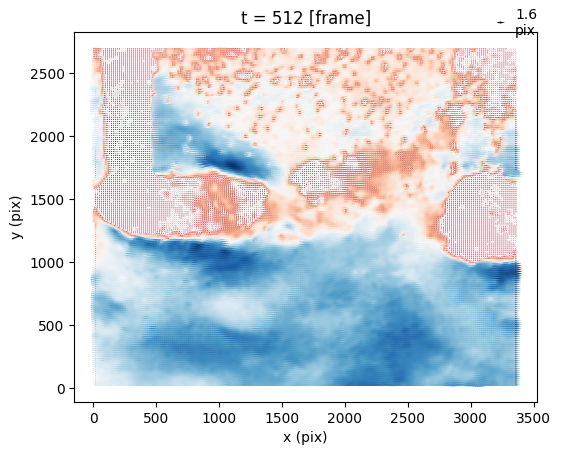

In [301]:
File_num = 500
#d.isel(t=701).piv.quiver()
Time_Slice= d.sel(t=File_num) #slicing the needed .vec file (t=700 -> 699th file)
ONE_VEC_xarray = Time_Slice.expand_dims(t=[0]) #initializing a time dimention for the slicing to be an xarray with x,y,t dimentions
from pivpy import pivpy 
d.isel(t=File_num).piv.quiver()

Now we will convert the xarray format to a NETCFD type,this is the file type needed to anlyize the vortecies.
We will save the data in NetCDF format in the path of "saveNcFile".

In [302]:
vfField = inter.pivpyTOvf(ONE_VEC_xarray, saveNcFile)

Now we will start vortex analsys:

In [303]:
#Vorticity calculations:
vfFieldDerivative = vfSchemes.fourth_order_diff(vfField) #Takes in the velocity field and returns a dictionary
vorticity = vfFieldDerivative['dvdx'] - vfFieldDerivative['dudy'] #vorticity is a 2D array with vorticity value at each point
max_vorticity = np.max(vorticity) #Finding max vorticity for intuation for sst(threshhold)
print("Maximum vorticity: {}".format(max_vorticity))

Difference scheme: Fourth Order Scheme
Maximum vorticity: 0.1113174373263889


In [304]:
vortexDetect = vfDetection.calc_q_criterion(vfField) #Vortex analysis using "Q_criteriation"

sst = 0.0006 # This is a threshold for swirling strength, a measure of how much the fluid is swirling. Vortices below this threshold won't be considered.

bs = 3 #Box size—an integer distance used to separate vortices in the mesh/grid. It helps avoid overlapping vortices.

peaks = vfFitting.find_peaks(vortexDetect, sst, bs) # A list of points where the swirls are strongest, indicating potential vortex centers.

print('Num of Vortices found: ', len(peaks[0])) #prints the number of vortices detected

Detection method: Q criterion
Num of Vortices found:  12


In [305]:
vortices_counterclockwise, vortices_clockwise = vfFitting.direction_rotation(vorticity, peaks) 
#classify vortices as either clockwise or counterclockwise rotating

In [306]:
rmax = 100 # initial guess of the vortex radius

ch = 0.5 # correlation threshold - a parameter used in get_vortices() function; reduce it if the vortex is too big. Higher values make the detection stricter.

vortices = vfFitting.get_vortices(vfField, peaks, vorticity, rmax, ch) #filters out noise and refines the detected vortices based on the peaks, vorticity, radius guess, and correlation threshold.

print('---- Accepted vortices ----')
print(len(vortices))

0 Processing detected swirling at (x, y) 202 61
Accepted! Correlation = 0.64 (vortex # 0)
1 Processing detected swirling at (x, y) 68 69
Accepted! Correlation = 0.77 (vortex # 1)
2 Processing detected swirling at (x, y) 54 71
Accepted! Correlation = 0.67 (vortex # 2)
3 Processing detected swirling at (x, y) 44 73
Accepted! Correlation = 0.69 (vortex # 3)
4 Processing detected swirling at (x, y) 93 74
Accepted! Correlation = 0.60 (vortex # 4)
5 Processing detected swirling at (x, y) 98 76
Accepted! Correlation = 0.77 (vortex # 5)
6 Processing detected swirling at (x, y) 106 87
Accepted! Correlation = 0.66 (vortex # 6)
7 Processing detected swirling at (x, y) 175 92
8 Processing detected swirling at (x, y) 76 102
Accepted! Correlation = 0.67 (vortex # 7)
9 Processing detected swirling at (x, y) 40 104
Accepted! Correlation = 0.69 (vortex # 8)
10 Processing detected swirling at (x, y) 70 104
Accepted! Correlation = 0.67 (vortex # 9)
11 Processing detected swirling at (x, y) 59 108
Accepte

Now we will plot our analasys:

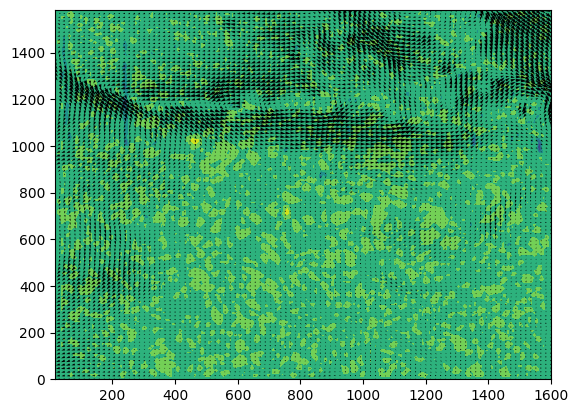

In [307]:
"""Plots arrows (a quiver plot) representing the velocity field (u_data, v_data) along with the detected vortices"""
x_index, y_index, u_data, v_data = vfFitting.window(vfField, 0, 0, rmax)
vfFitting.plot_quiver(x_index, y_index, u_data, v_data, vortexDetect)


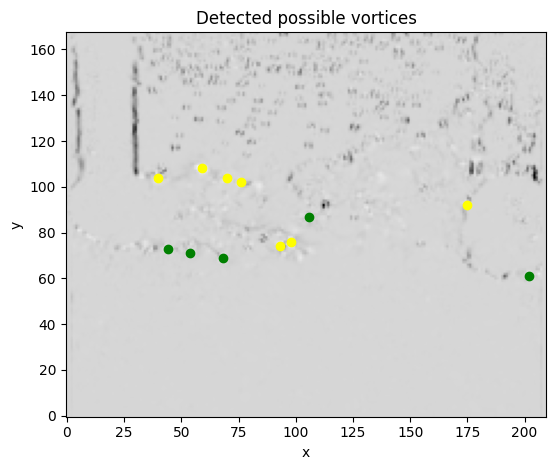

In [308]:
# Plot location and rotation of the vortices.
vfFitting.plot_detect(vortices_counterclockwise, vortices_clockwise, vortexDetect, 0)

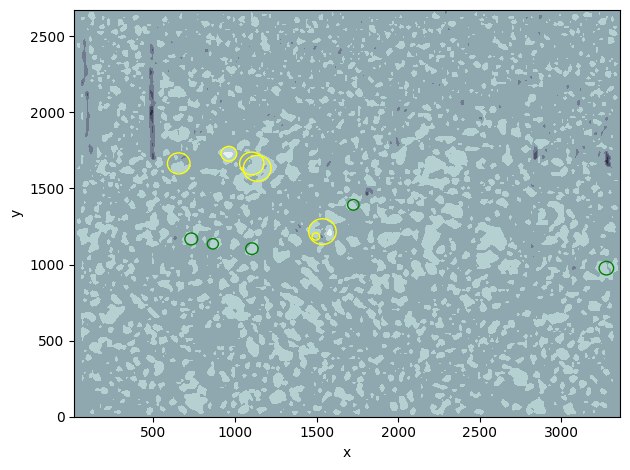

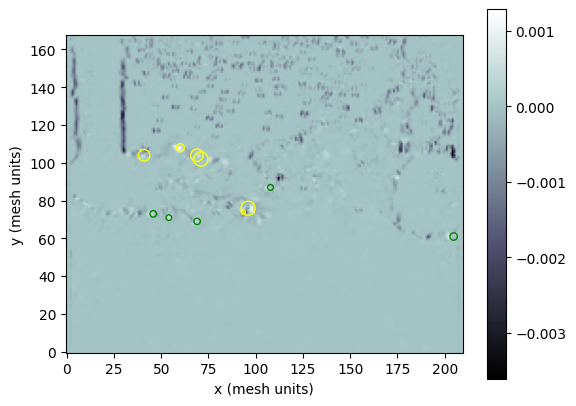

In [309]:
# Plot accepted vortices
vfFitting.plot_accepted(vfField, vortices, vortexDetect, str(saveToDir), 0, 'png')

Now after understanding how to detect vortecies and selecting the threshhold we will define the area of intrest.
We will look for vortecies with inside the area of intrest and count how many times we detect vortex in the area.

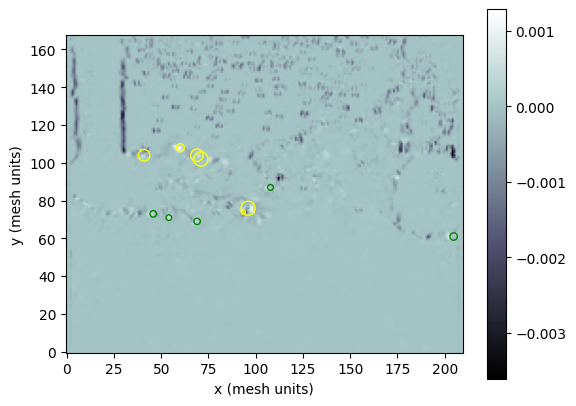

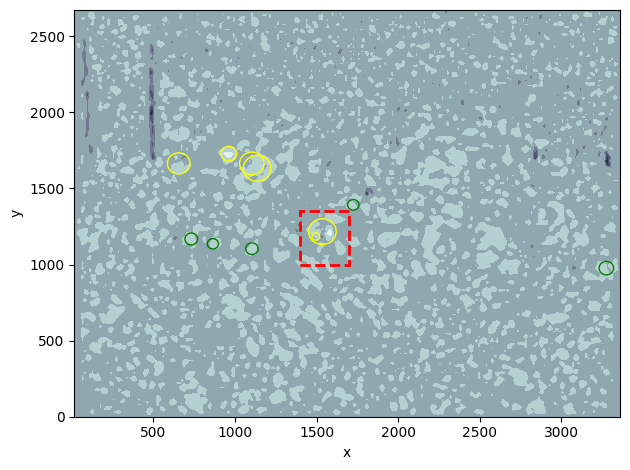

In [310]:
# Define area of interest (AOI):
x_min, x_max = 1400, 1700  # x-coordinates of AOI
y_min, y_max = 1000, 1350  # y-coordinates of AOI

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plotting AOI for better visualization:
def plot_vortices_with_AOI(vfField, vortices, vortexDetect, saveToDir, img_index, file_format, x_min, x_max, y_min, y_max):
    # Call the original plot function to plot vortices
    vfFitting.plot_accepted(vfField, vortices, vortexDetect, str(saveToDir), img_index, file_format)

    # Switch to figure(1) where the pixel-based plot is located
    plt.figure(1)
    
    # Add a red rectangle for the AOI
    ax = plt.gca()   # Get the current axis of figure 1
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
    
    # Add the rectangle to the pixel plot (figure 1)
    ax.add_patch(rect)

    # Save or display the updated plot with the AOI
    plt.savefig(f"{saveToDir}/accepted_with_AOI_{img_index}.{file_format}", format=file_format)
    plt.show()

# Plotting:
plot_vortices_with_AOI(vfField, vortices, vortexDetect, saveToDir, 0, 'png', x_min, x_max, y_min, y_max)


Now we will define a function that determine if a vortex is inside the AOI:

In [311]:
def is_vortex_in_AOI(vortices, x_min, x_max, y_min, y_max):
    """
    Checks if any accepted vortex lies inside the defined area of interest (AOI).

    Parameters:
    vortices (list): List of accepted vortices. Each vortex entry is a list where
                     index 2 is the x-coordinate and index 3 is the y-coordinate.
    x_min (float): Minimum x-coordinate of the AOI.
    x_max (float): Maximum x-coordinate of the AOI.
    y_min (float): Minimum y-coordinate of the AOI.
    y_max (float): Maximum y-coordinate of the AOI.

    Returns:
    bool: True if any vortex is inside the AOI, False otherwise.
    """
    for vortex in vortices:
        x = vortex[2]  # x-coordinate of the vortex
        y = vortex[3]  # y-coordinate of the vortex
        # Check if the vortex is inside the AOI
        if x_min <= x <= x_max and y_min <= y <= y_max:
            return True  # At least one vortex is inside the AOI
    
    return False  # No vortices found inside the AOI

# Example usage:
result = is_vortex_in_AOI(vortices, x_min, x_max, y_min, y_max)
print(result)  # True if a vortex is inside the AOI, False otherwise.

True


Vortex detection:
Now we will run on all the PIV vector filtes and count how many times there was a vortex inside the AOI:

In [321]:
Vortices_In_AOI=0
for t in range(500,899):
    File_num = t
    Time_Slice= d.sel(t=File_num) #slicing the needed .vec file (t=700 -> 699th file)
    ONE_VEC_xarray = Time_Slice.expand_dims(t=[0]) #initializing a time dimention for the slicing to be an xarray with x,y,t dimentions
    vfField = inter.pivpyTOvf(ONE_VEC_xarray, saveNcFile)
    
    #Vorticity calculations:
    vfFieldDerivative = vfSchemes.fourth_order_diff(vfField) #Takes in the velocity field and returns a dictionary
    vorticity = vfFieldDerivative['dvdx'] - vfFieldDerivative['dudy'] #vorticity is a 2D array with vorticity value at each point
    
    #Threshhold calculation:
    vortexDetect = vfDetection.calc_q_criterion(vfField) #Vortex analysis using "Q_criteriation"
    sst = 0.0006 # This is a threshold for swirling strength, a measure of how much the fluid is swirling. Vortices below this threshold won't be considered.
    bs = 3 #Box size—an integer distance used to separate vortices in the mesh/grid. It helps avoid overlapping vortices.
    peaks = vfFitting.find_peaks(vortexDetect, sst, bs) # A list of points where the swirls are strongest, indicating potential vortex centers.
    vortices_counterclockwise, vortices_clockwise = vfFitting.direction_rotation(vorticity, peaks) 
    rmax = 100 # initial guess of the vortex radius
    ch = 0.5 # correlation threshold - a parameter used in get_vortices() function; reduce it if the vortex is too big. Higher values make the detection stricter.
    vortices = vfFitting.get_vortices(vfField, peaks, vorticity, rmax, ch) #filters out noise and refines the detected vortices based on the peaks, vorticity, radius guess, and correlation threshold.
    
    #Define AOI:
    x_min, x_max = 1400, 1700  # x-coordinates of AOI
    y_min, y_max = 1000, 1350  # y-coordinates of AOI
    result = is_vortex_in_AOI(vortices, x_min, x_max, y_min, y_max)
    if result == True:
        Vortices_In_AOI+=1
print("Done calculating Vortices_In_AOI:")
print("There are {} vortices in the AOI".format(Vortices_In_AOI))


Difference scheme: Fourth Order Scheme
Detection method: Q criterion
0 Processing detected swirling at (x, y) 42 71
Accepted! Correlation = 0.83 (vortex # 0)
1 Processing detected swirling at (x, y) 85 86
Accepted! Correlation = 0.82 (vortex # 1)
2 Processing detected swirling at (x, y) 33 105
Accepted! Correlation = 0.53 (vortex # 2)
3 Processing detected swirling at (x, y) 63 109
Difference scheme: Fourth Order Scheme
Detection method: Q criterion
0 Processing detected swirling at (x, y) 37 73
Accepted! Correlation = 0.72 (vortex # 0)
1 Processing detected swirling at (x, y) 28 74
Accepted! Correlation = 0.62 (vortex # 1)
2 Processing detected swirling at (x, y) 57 75
Accepted! Correlation = 0.88 (vortex # 2)
3 Processing detected swirling at (x, y) 11 78
Accepted! Correlation = 0.54 (vortex # 3)
4 Processing detected swirling at (x, y) 37 78
Accepted! Correlation = 0.69 (vortex # 4)
5 Processing detected swirling at (x, y) 130 82
Accepted! Correlation = 0.90 (vortex # 5)
6 Processin